<div align = 'center'> Project 1 - Linear Regression and Model Comparison (LBA) 
    
<div align = 'center'> Macbeth K. Matibe
    
<div align = 'center'> Minerva University
    
<div align = 'center'> CS146: Computational Methods for Bayesian Statistics
    
<div align = 'center'> Prof. Volkan
    
<div align = 'center'> October 21, 2023

data source --> https://archive.ics.uci.edu/dataset/477/real+estate+valuation+data+set 


Real estate valuation data set. (2018). UCI Machine Learning Repository. https://doi.org/10.24432/C5J30W. 

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as sts

# Load the data from the CSV file
real_estate = pd.read_csv('Real estate.csv', encoding = "utf-8")
print('This is the Real Estate data')
real_estate = real_estate[real_estate['Y house price of unit area'] <= 100]
real_estate.head()

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


This is the Real Estate data


No  X1 transaction date  X2 house age  \
0   1             2012.917          32.0   
1   2             2012.917          19.5   
2   3             2013.583          13.3   
3   4             2013.500          13.3   
4   5             2012.833           5.0   

   X3 distance to the nearest MRT station  X4 number of convenience stores  \
0                                84.87882                               10   
1                               306.59470                                9   
2                               561.98450                                5   
3                               561.98450                                5   
4                               390.56840                                5   

   X5 latitude  X6 longitude  Y house price of unit area  
0     24.98298     121.54024                        37.9  
1     24.98034     121.53951                        42.2  
2     24.98746     121.54391                        47.3  
3     24.98746     121.54391                        54.8  
4     24.97937     121.54245                        43.1

In [13]:
# Set the default credible interval used by arviz
az.rcParams["stats.hdi_prob"] = 0.89

# Display information about each of the variables (columns) in the data set
az.summary(real_estate.to_dict(orient="list"), kind="stats")

mean        sd  hdi_5.5%  \
No                                       207.346   119.760     1.000   
X1 transaction date                     2013.149     0.282  2012.667   
X2 house age                              17.729    11.401     0.000   
X3 distance to the nearest MRT station  1085.899  1262.975    23.383   
X4 number of convenience stores            4.102     2.945     0.000   
X5 latitude                               24.969     0.012    24.948   
X6 longitude                             121.533     0.015   121.510   
Y house price of unit area                37.788    13.046    17.400   

                                        hdi_94.5%  
No                                        369.000  
X1 transaction date                      2013.500  
X2 house age                               34.500  
X3 distance to the nearest MRT station   2469.645  
X4 number of convenience stores             8.000  
X5 latitude                                24.986  
X6 longitude                              121.552  
Y house price of unit area                 58.100

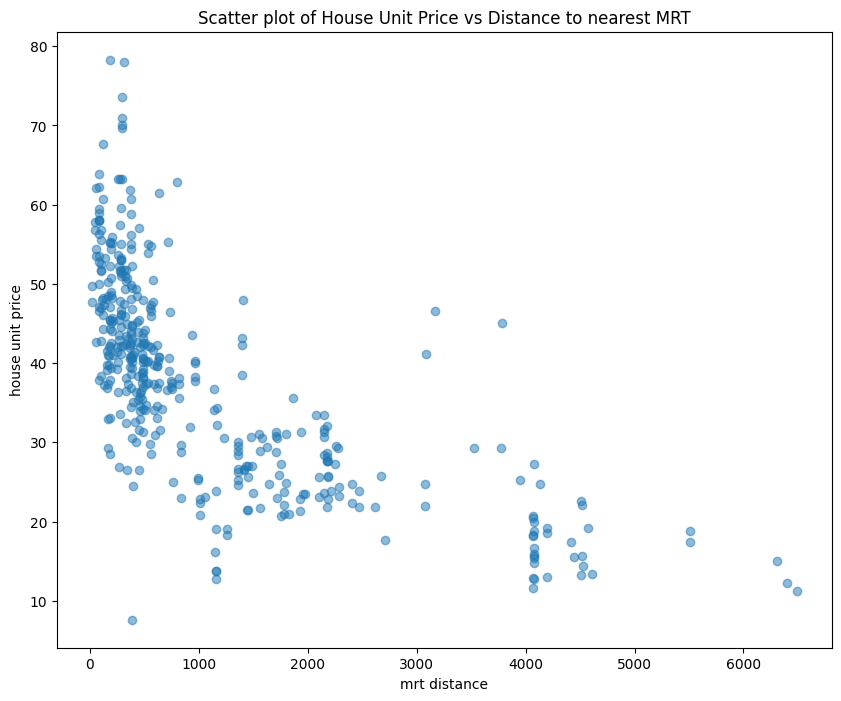

In [9]:
plt.figure(figsize=(10,8))  # Adjust figure size 
plt.scatter(real_estate['X3 distance to the nearest MRT station'],
            real_estate['Y house price of unit area'], alpha=0.5)
plt.title(f'Scatter plot of House Unit Price vs Distance to nearest MRT')
plt.ylabel('house unit price')
plt.xlabel('mrt distance')
plt.show()

In [10]:
with pm.Model() as model:
    
    # YOUR PRIORS GO HERE
    c0 = pm.TruncatedNormal('c0', mu= 4, sigma = 5, lower = 0, upper = 100) # this is the mean of the mean!
    c1 = pm.TruncatedNormal('c1', mu=1, sigma = 5, lower = 0, upper = 100)
    sigma = pm.TruncatedNormal('sigma', mu = 5 , sigma = 3, lower = 0, upper = 100)
    
    # Data
    x = pm.MutableData('x', real_estate['X3 distance to the nearest MRT station'])
    # Regression mean
    mu = pm.Deterministic('mu', c0 + c1 * x)
    # Likelihood
    pm.Normal('y', mu=mu, sigma=sigma, observed=real_estate['Y house price of unit area'])


Sampling: [c0, c1, sigma, y]


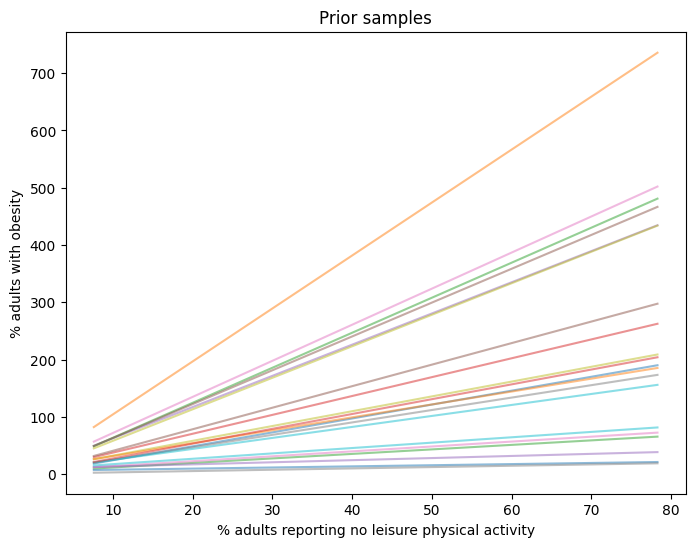

In [11]:
with model:
    inference = pm.sample_prior_predictive(20)

plt.figure(figsize=(8, 6))
plt.title('Prior samples')
plt.xlabel('% adults reporting no leisure physical activity')
plt.ylabel('% adults with obesity')
plot_x = np.array([unit_price.min(), unit_price.max()])
plot_y = (
    inference.prior.c0.values +
    plot_x.reshape(-1, 1) * inference.prior.c1.values)
plt.plot(plot_x, plot_y, alpha=0.5)
plt.show()

# QUESTION: this plot only takes into account c0 and c1

In [12]:
with model:
    inference = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c0, c1, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 375 seconds.
/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1152 divergences after tuning. Increase `tar

In [13]:
az.summary(inference, var_names=['c0', 'c1', 'sigma'])

mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
c0      0.0  0.0     0.0      0.0        0.0      0.0       4.0      14.0   
c1      1.0  0.0     1.0      1.0        0.0      0.0       5.0      36.0   
sigma   0.0  0.0     0.0      0.0        0.0      0.0       5.0      19.0   

       r_hat  
c0      3.38  
c1      2.76  
sigma   3.02

/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


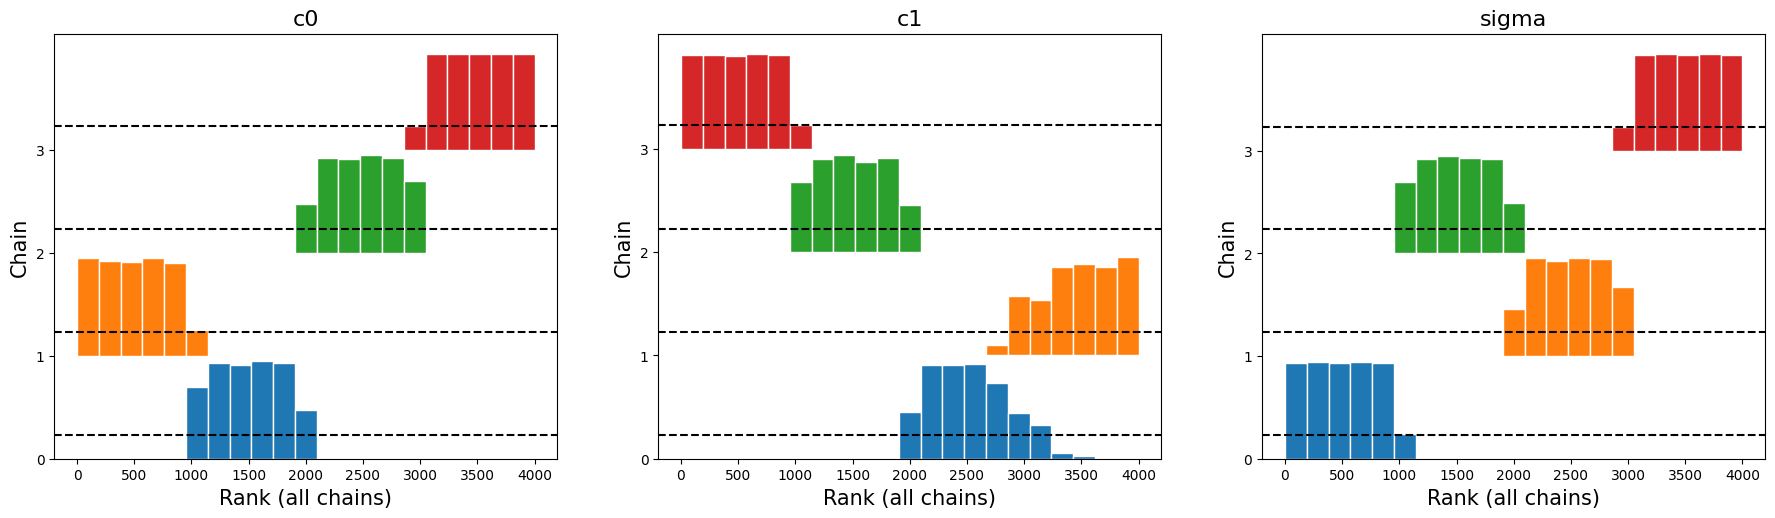

In [14]:
az.plot_rank(inference, var_names=['c0', 'c1', 'sigma']);

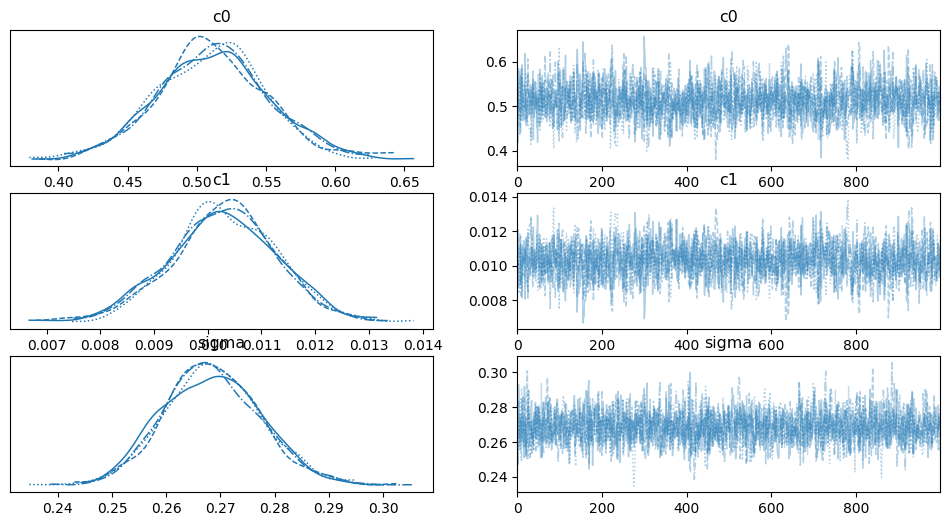

In [55]:
az.plot_trace(inference, var_names=['c0', 'c1', 'sigma']);

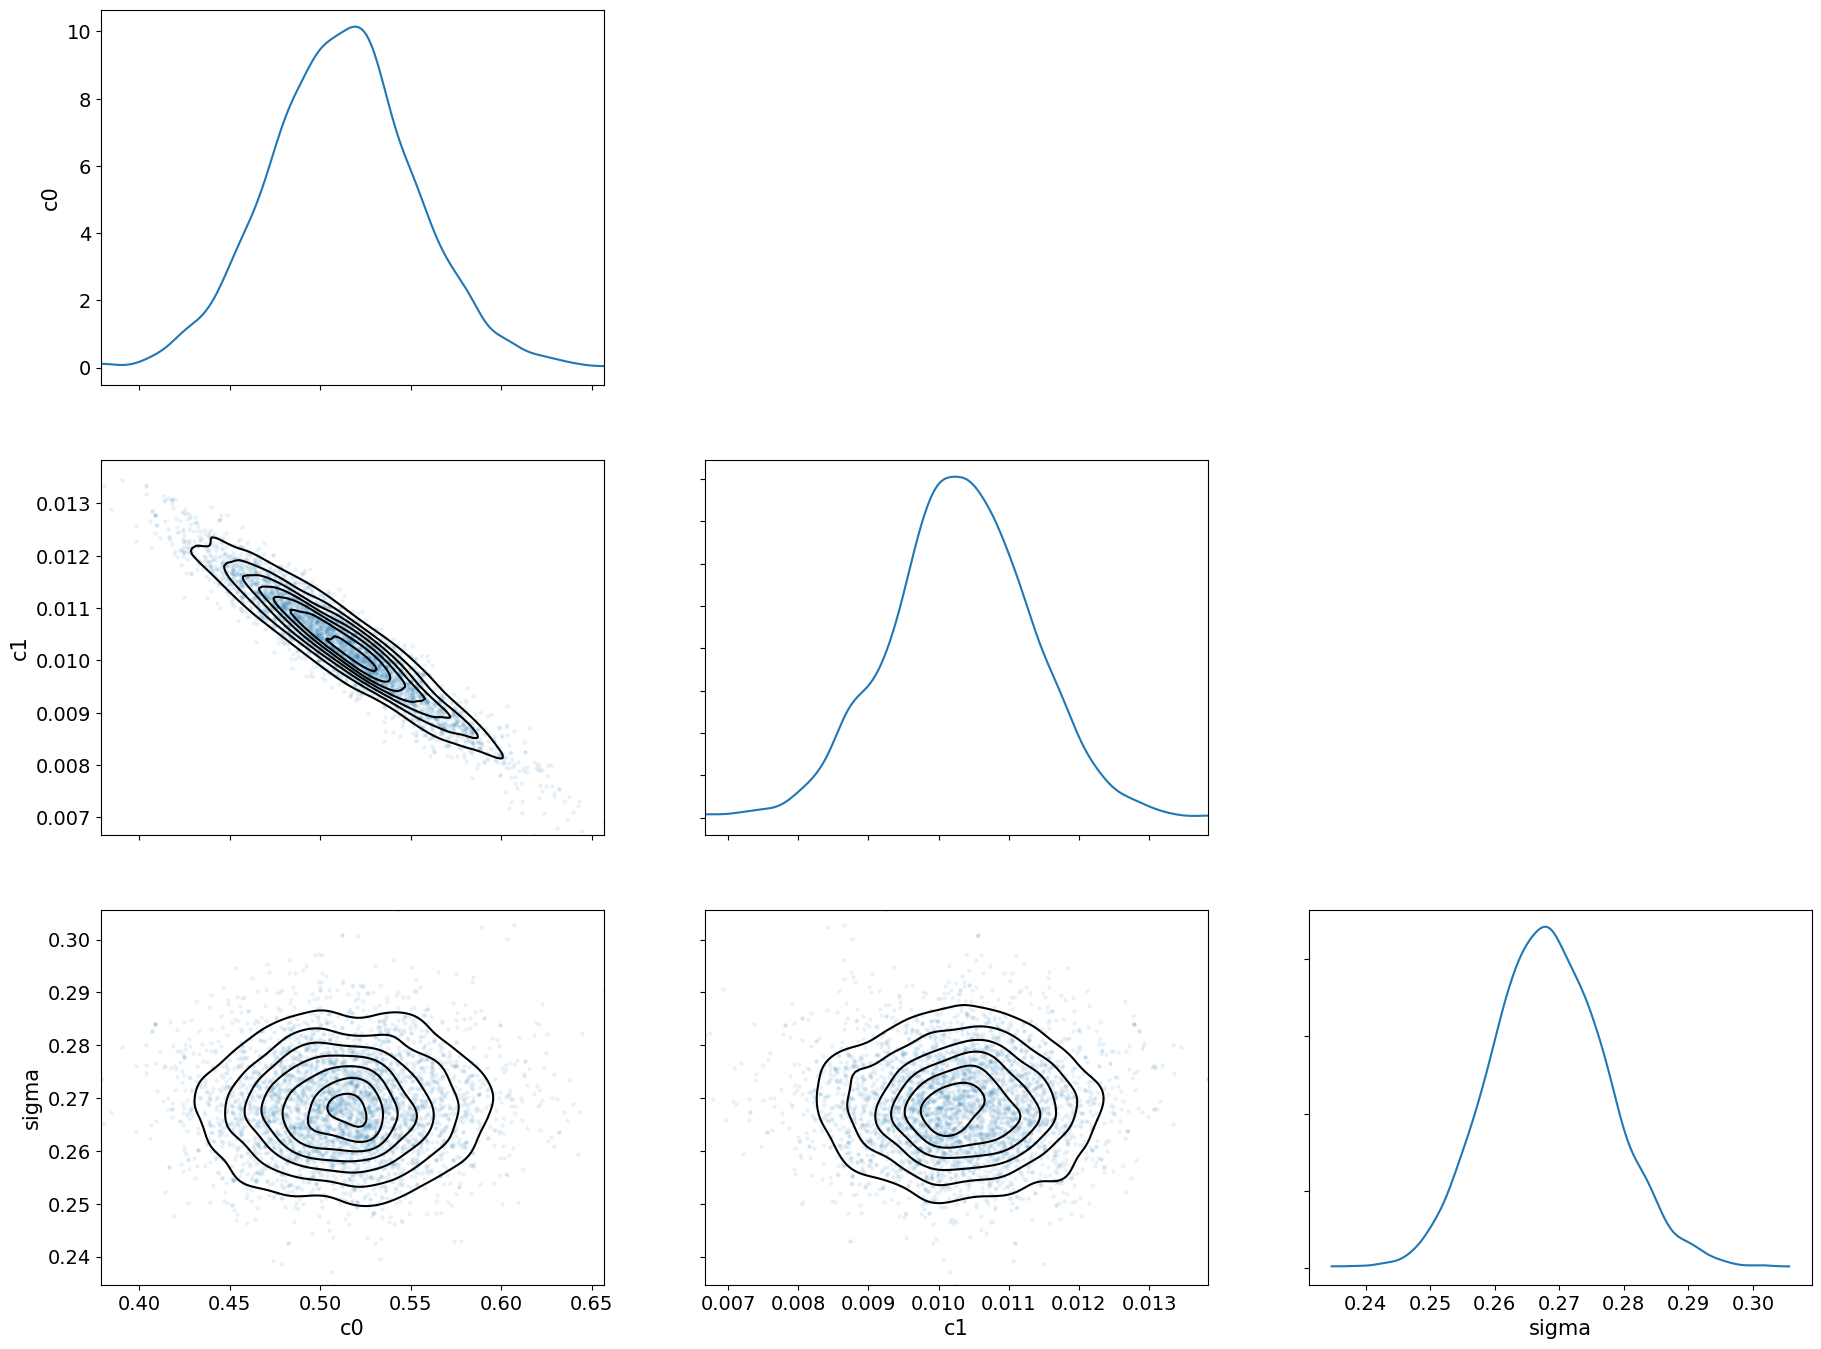

In [56]:
ax = az.plot_pair(
    inference,
    var_names=['c0', 'c1', 'sigma'],
    marginals=True,
    kind=["scatter", "kde"],
    scatter_kwargs={"color": "C0", "alpha": 0.1},
    marginal_kwargs={"kind": "kde", "color": "C0"},
    kde_kwargs={"contour_kwargs": {"colors": "k", 'alpha': 1}});

/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


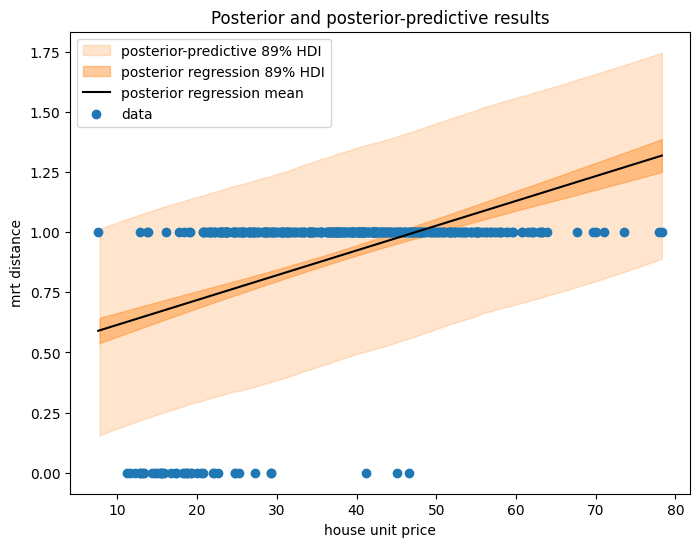

In [57]:
posterior_samples = inference.posterior.stack(
    sample=('chain', 'draw')).transpose('sample', ...)

# Compute posterior mu samples
plot_x = np.linspace(unit_price.min(), unit_price.max(), 200)
posterior_mu = (
    posterior_samples.c0.values.reshape(1, -1) +
    plot_x.reshape(-1, 1) * posterior_samples.c1.values.reshape(1, -1))

# Generate posterior-predictive y samples
posterior_y = sts.norm.rvs(
    loc = posterior_mu,
    scale=posterior_samples.sigma.values.reshape(1, -1),
    size=posterior_mu.shape)

# Plot posterior density intervals
plt.figure(figsize=(8, 6))
plt.title('Posterior and posterior-predictive results')
plt.xlabel('house unit price')
plt.ylabel('mrt distance')
ax = az.plot_hdi(plot_x, posterior_y.transpose(), hdi_prob=0.89, color='C1', fill_kwargs={'alpha': 0.2, 'label': 'posterior-predictive 89% HDI'})
az.plot_hdi(plot_x, posterior_mu.transpose(), ax=ax, hdi_prob=0.89, color='C1', fill_kwargs={'alpha': 0.4, 'label': 'posterior regression 89% HDI'})
plt.plot(plot_x, posterior_mu.mean(axis=1), color='black', label='posterior regression mean')
plt.scatter(unit_price, mrt_distance, color='C0', label='data')
plt.legend()
plt.show()

In [17]:
# Another Model
# Another Model
real_estate["unit_price_std"] = (unit_price - unit_price.mean()) / unit_price.std()
real_estate["unit_price_std2"] = real_estate.unit_price_std**2

with pm.Model() as m_4_5:
    a = pm.Normal("a", mu=178, sigma=100)
    b1 = pm.Lognormal("b1", mu=0, sigma=1)
    b2 = pm.Normal("b2", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + b1 * real_estate.unit_price_std.values + b2 * real_estate.unit_price_std2.values)
    mrt_distance_obs = pm.Normal("mrt_distance", mu=mu, sigma=sigma, observed=mrt_distance.values)
    trace_4_5 = pm.sample(1000, tune=1000)


/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/pytensor/tensor/rewriting/elemwise.py:1019: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/pytensor/tensor/rewriting/elemwise.py:1019: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b1, b2, sigma]
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implem

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 108 seconds.


mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a      1027.630  2.569  1023.804   1031.927      0.044    0.031    3481.0   
b2       57.881  0.862    56.603     59.304      0.015    0.011    3262.0   
b1        0.025  0.012     0.008      0.042      0.000    0.000    2959.0   
sigma    50.000  0.000    50.000     50.000      0.000    0.000    2746.0   

       ess_tail  r_hat  
a        3248.0    1.0  
b2       2849.0    1.0  
b1       2812.0    1.0  
sigma    1649.0    1.0

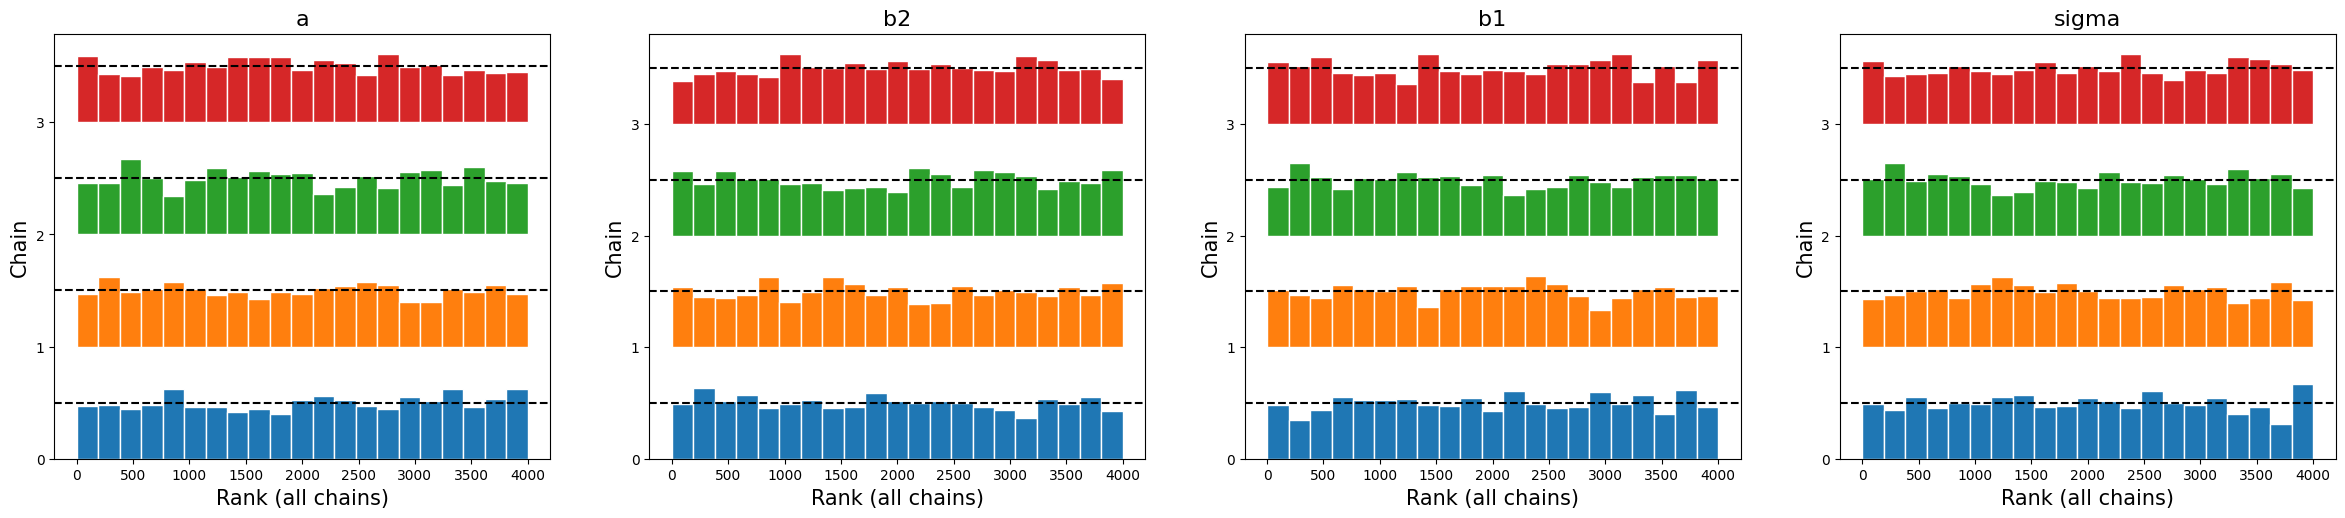

In [19]:
varnames = ["~mu"]  # all variables except mu
az.plot_rank(trace_4_5, varnames)
az.summary(trace_4_5, varnames)

In [20]:
az.summary(trace_4_5, varnames, kind="stats", round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%
a      1027.63  2.57   1023.80    1031.93
b2       57.88  0.86     56.60      59.30
b1        0.03  0.01      0.01       0.04
sigma    50.00  0.00     50.00      50.00

In [23]:
mu_pred = trace_4_5.posterior["mu"]
trace_4_5_thinned = trace_4_5.sel(draw=slice(None, None, 5))
with m_4_5:
    mrt_distance_pred = pm.sample_posterior_predictive(trace_4_5_thinned)

Sampling: [mrt_distance]


In [27]:
print(mrt_distance_pred.posterior_predictive.keys())


KeysView(<xarray.Dataset>
Dimensions:             (chain: 4, draw: 200, mrt_distance_dim_2: 413)
Coordinates:
  * chain               (chain) int64 0 1 2 3
  * draw                (draw) int64 0 5 10 15 20 25 ... 970 975 980 985 990 995
  * mrt_distance_dim_2  (mrt_distance_dim_2) int64 0 1 2 3 4 ... 409 410 411 412
Data variables:
    mrt_distance        (chain, draw, mrt_distance_dim_2) float64 907.4 ... 1...
Attributes:
    created_at:                 2023-10-13T15:36:47.158390
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.6.1)


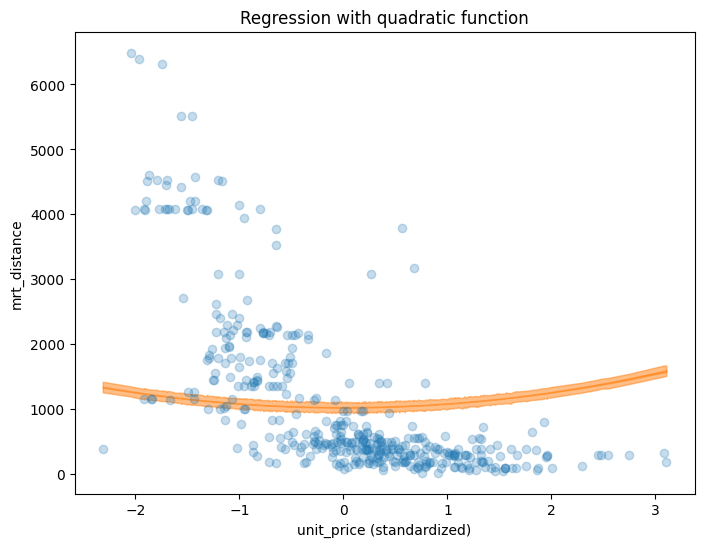

In [33]:
plt.figure(figsize=(8, 6))
plt.title('Regression with quadratic function')
ax = az.plot_hdi(real_estate.unit_price_std, mu_pred, smooth=False)
az.plot_hdi(real_estate.unit_price_std, mrt_distance_pred.posterior_predictive['mrt_distance'], ax=ax, smooth=False)
plt.scatter(real_estate.unit_price_std, real_estate['X3 distance to the nearest MRT station'], c="C0", alpha=0.25)
plt.xlabel('unit_price (standardized)')
plt.ylabel('mrt_distance');

In [ ]:
mrt_distance = real_estate['X3 distance to the nearest MRT station'] 
house_age = real_estate['X2 house age']
unit_price = real_estate['Y house price of unit area']

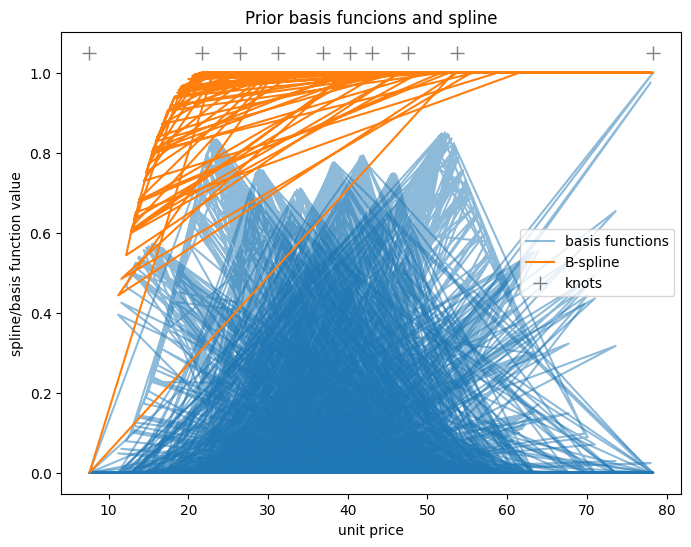

In [36]:
from patsy import dmatrix

degree = 2
num_knots = 10
knot_list = np.quantile(unit_price, np.linspace(0, 1, num_knots))
B = dmatrix(
    'bs(unit_price, knots=knots, degree=degree, include_intercept=False)-1',
    {'time': unit_price, 'knots': knot_list[1:-1], 'degree': degree})

plt.figure(figsize=(8, 6))
plt.title('Prior basis funcions and spline')
total = np.zeros(len(unit_price))
for i in range(B.shape[1]):
    total += B[:, i]
    plt.plot(unit_price, B[:, i], color='C0', alpha=0.5, label='basis functions' if i == 0 else None)
plt.plot(unit_price, total, color='C1', label='B-spline')
plt.plot(knot_list, np.full(len(knot_list), total.max() * 1.05), 'k+', alpha=0.5, markersize=10, label='knots')
plt.xlabel('unit price')
plt.ylabel('spline/basis function value')
plt.legend()
plt.show()

In [37]:
with pm.Model() as model_2:
    a_mu = pm.Normal("a_mu", mu=0, sigma=100)
    w_mu = pm.Normal("w_mu", mu=0, sigma=100, shape=B.shape[1])
    mu = pm.Deterministic("mu", a_mu + pm.math.dot(np.asarray(B, order="F"), w_mu.T))
    a_sigma = pm.Normal("a_sigma", mu=0, sigma=10)
    w_sigma = pm.Normal("w_sigma", mu=0, sigma=10, shape=B.shape[1])
    sigma = pm.Deterministic("sigma", pm.math.exp(a_sigma + pm.math.dot(np.asarray(B, order="F"), w_sigma.T))) # change sigma using B-spline function
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=real_estate['X3 distance to the nearest MRT station'])
    inference_2 = pm.sample(1000)
    pm.sample_posterior_predictive(inference_2, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_mu, w_mu, a_sigma, w_sigma]
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove

/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/pytensor/scalar/basic.py:3092: RuntimeWarning: overflow encountered in exp
  return np.exp(x)
/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/pytensor/scalar/basic.py:3092: RuntimeWarning: overflow encountered in exp
  return np.exp(x)
/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/pytensor/scalar/basic.py:3092: RuntimeWarning: overflow encountered in exp
  return np.exp(x)
/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/pytensor/scalar/basic.py:3092: RuntimeWarning: overflow encountered in exp
  return np.exp(x)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5866 seconds.
Sampling: [D]


/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


mean       sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
a_mu        443.057   41.106   378.034    508.860      0.845    0.598   
w_mu[0]      78.692  102.431   -88.023    234.012      1.421    1.506   
w_mu[1]     282.039   99.076   121.179    435.374      1.359    0.984   
w_mu[2]     261.203   96.523   107.437    412.356      1.419    1.023   
w_mu[3]     165.664   82.567    42.871    300.806      1.229    0.944   
w_mu[4]      51.327   67.569   -62.828    153.007      1.152    0.885   
w_mu[5]      30.639   72.488   -81.011    148.108      1.190    1.073   
w_mu[6]      25.283   77.770   -96.582    150.489      1.171    1.204   
w_mu[7]    -204.613   53.178  -294.355   -125.853      0.987    0.706   
w_mu[8]    -116.588   71.112  -232.467     -5.375      1.216    0.896   
w_mu[9]    -154.420   65.789  -255.280    -56.851      1.310    0.926   
a_sigma       7.630    0.604     6.680      8.591      0.023    0.017   
w_sigma[0]    1.358    0.920    -0.101      2.845      0.034    0.024   
w_sigma[1]   -0.514    0.562    -1.419      0.348      0.021    0.015   
w_sigma[2]   -0.276    0.657    -1.308      0.743      0.025    0.018   
w_sigma[3]   -1.386    0.625    -2.395     -0.426      0.023    0.017   
w_sigma[4]   -2.141    0.635    -3.218     -1.200      0.024    0.017   
w_sigma[5]   -1.521    0.616    -2.498     -0.559      0.023    0.017   
w_sigma[6]   -0.575    0.627    -1.610      0.362      0.024    0.017   
w_sigma[7]   -3.007    0.633    -4.034     -2.040      0.023    0.017   
w_sigma[8]   -1.478    0.714    -2.580     -0.312      0.024    0.017   
w_sigma[9]   -3.410    0.795    -4.699     -2.172      0.027    0.019   

            ess_bulk  ess_tail  r_hat  
a_mu          2366.0    2850.0    1.0  
w_mu[0]       5184.0    2549.0    1.0  
w_mu[1]       5319.0    3100.0    1.0  
w_mu[2]       4632.0    2968.0    1.0  
w_mu[3]       4526.0    2712.0    1.0  
w_mu[4]       3432.0    3347.0    1.0  
w_mu[5]       3712.0    2453.0    1.0  
w_mu[6]       4413.0    2980.0    1.0  
w_mu[7]       2907.0    2688.0    1.0  
w_mu[8]       3409.0    2839.0    1.0  
w_mu[9]       2758.0    2235.0    1.0  
a_sigma        677.0     887.0    1.0  
w_sigma[0]     734.0    1064.0    1.0  
w_sigma[1]     722.0    1093.0    1.0  
w_sigma[2]     704.0     986.0    1.0  
w_sigma[3]     732.0    1164.0    1.0  
w_sigma[4]     703.0     997.0    1.0  
w_sigma[5]     734.0    1106.0    1.0  
w_sigma[6]     697.0     830.0    1.0  
w_sigma[7]     755.0    1164.0    1.0  
w_sigma[8]     883.0    1499.0    1.0  
w_sigma[9]     856.0    1351.0    1.0

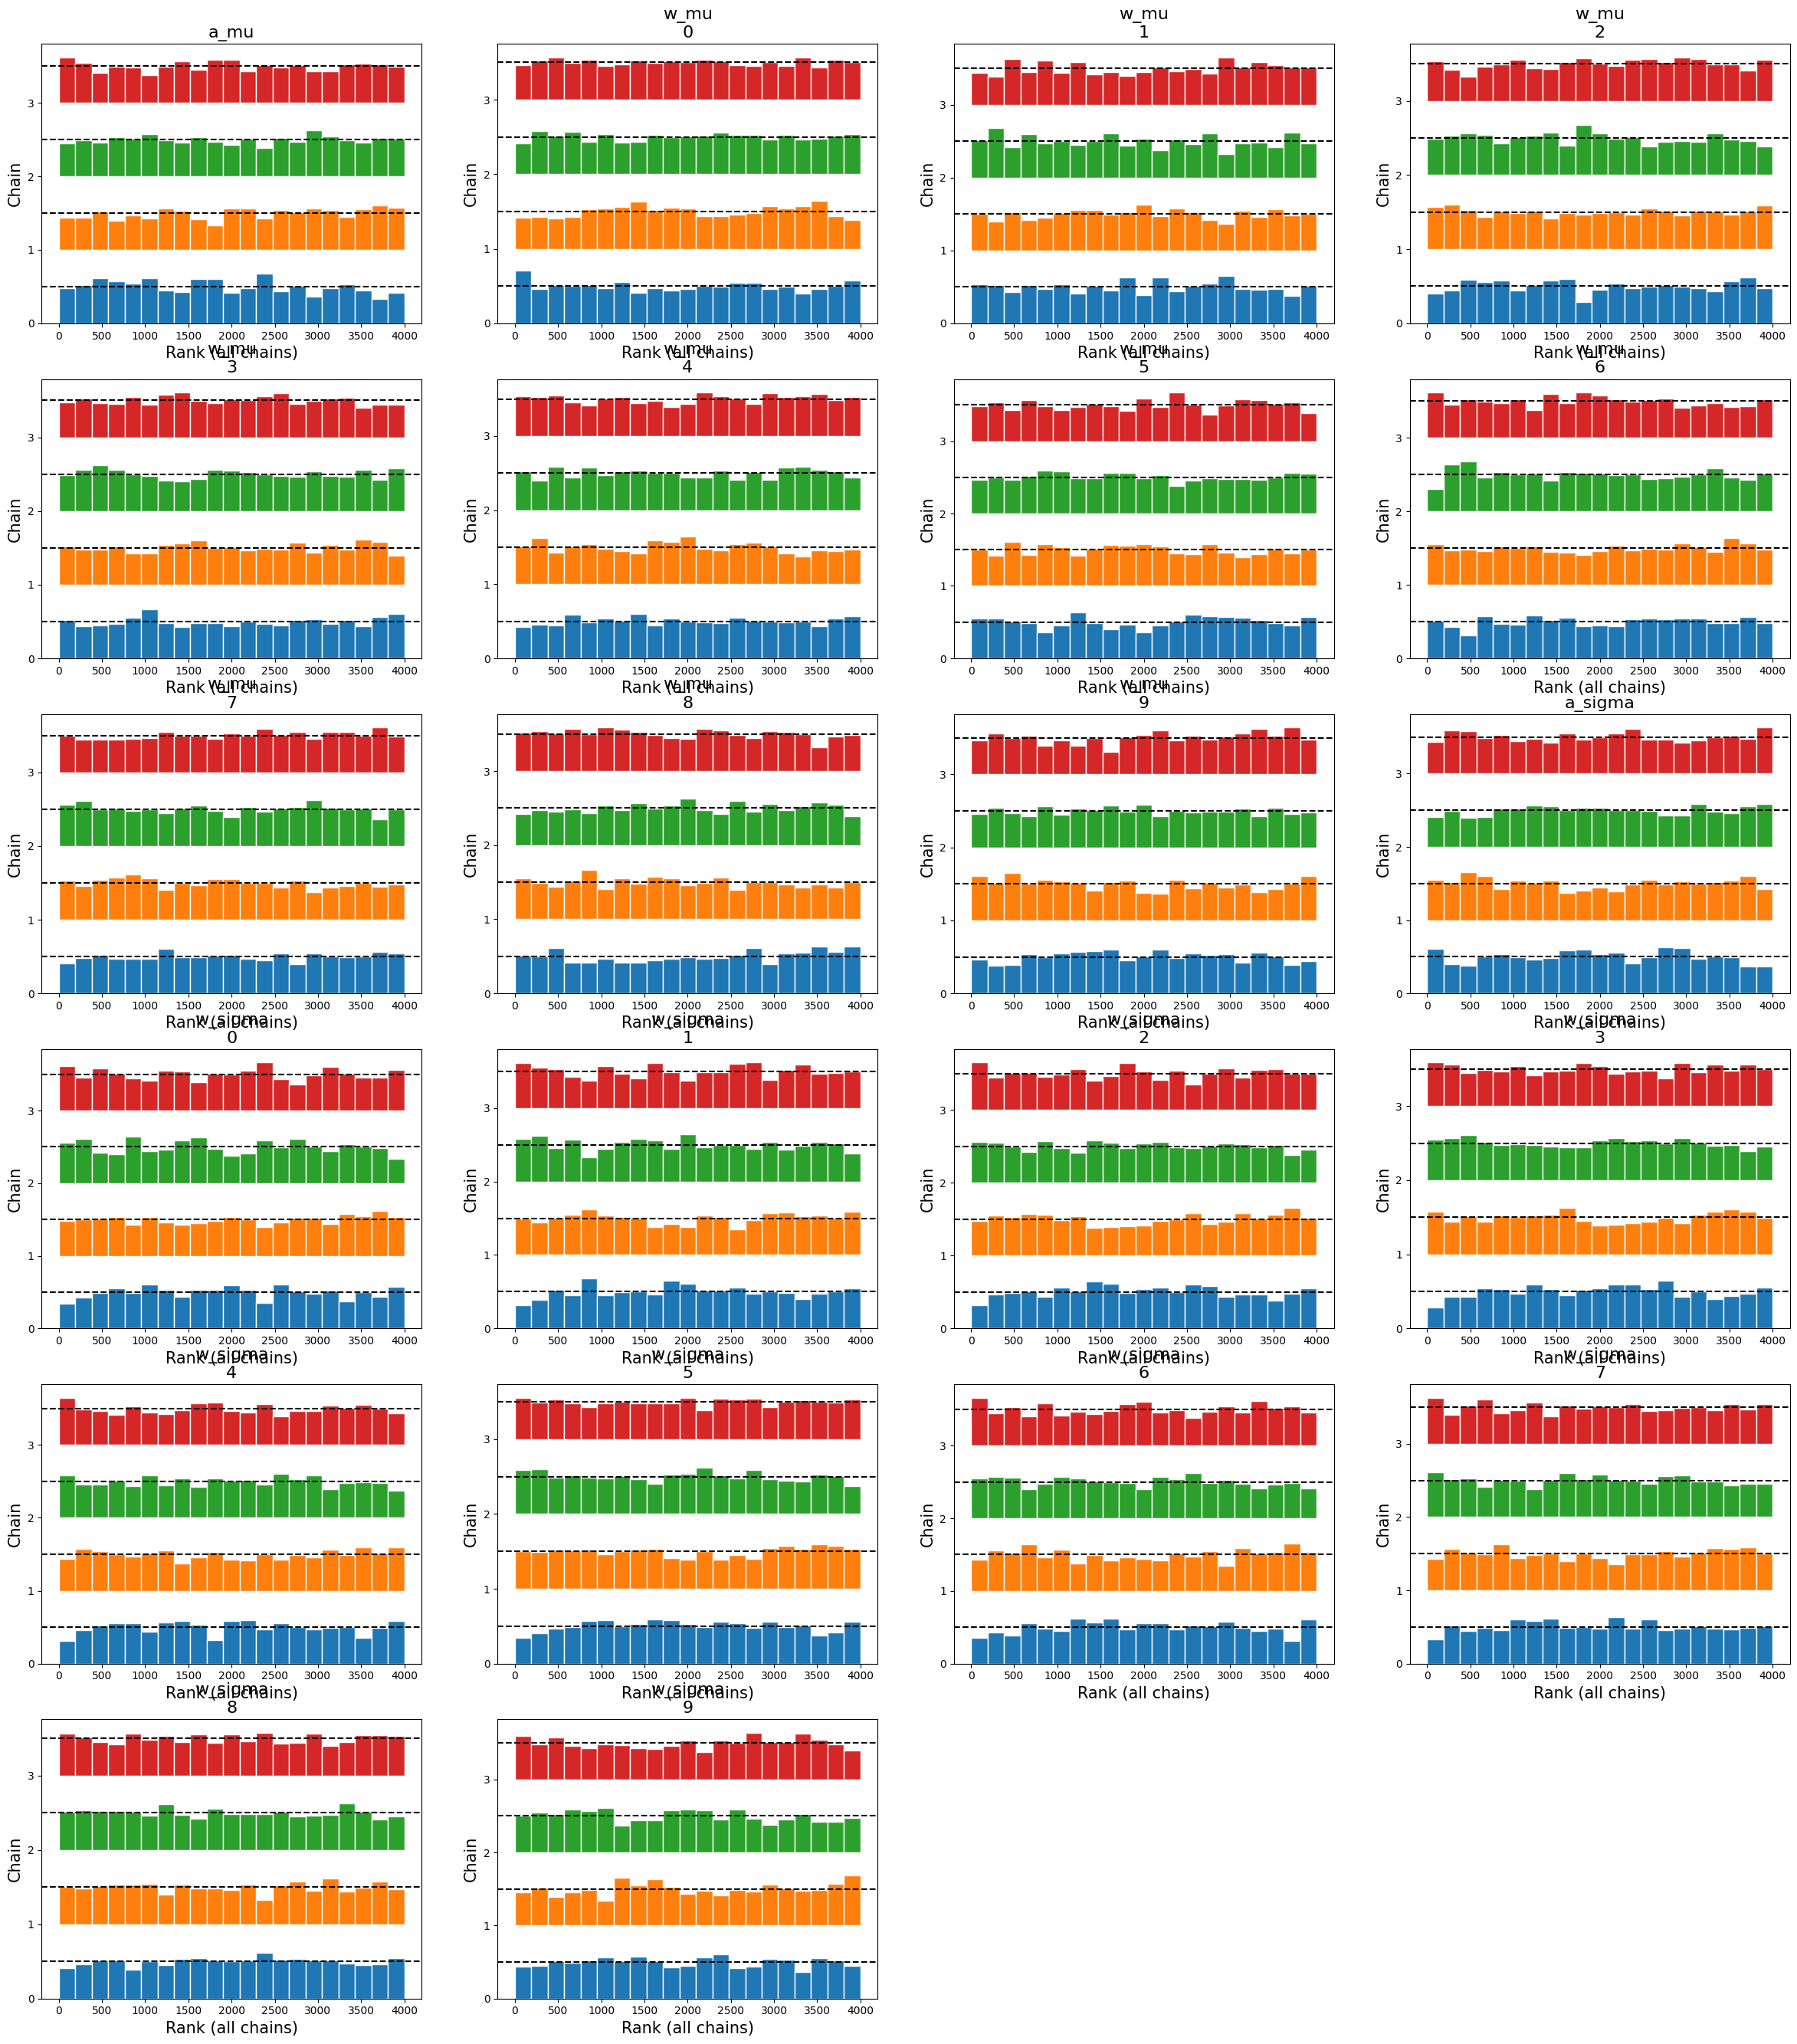

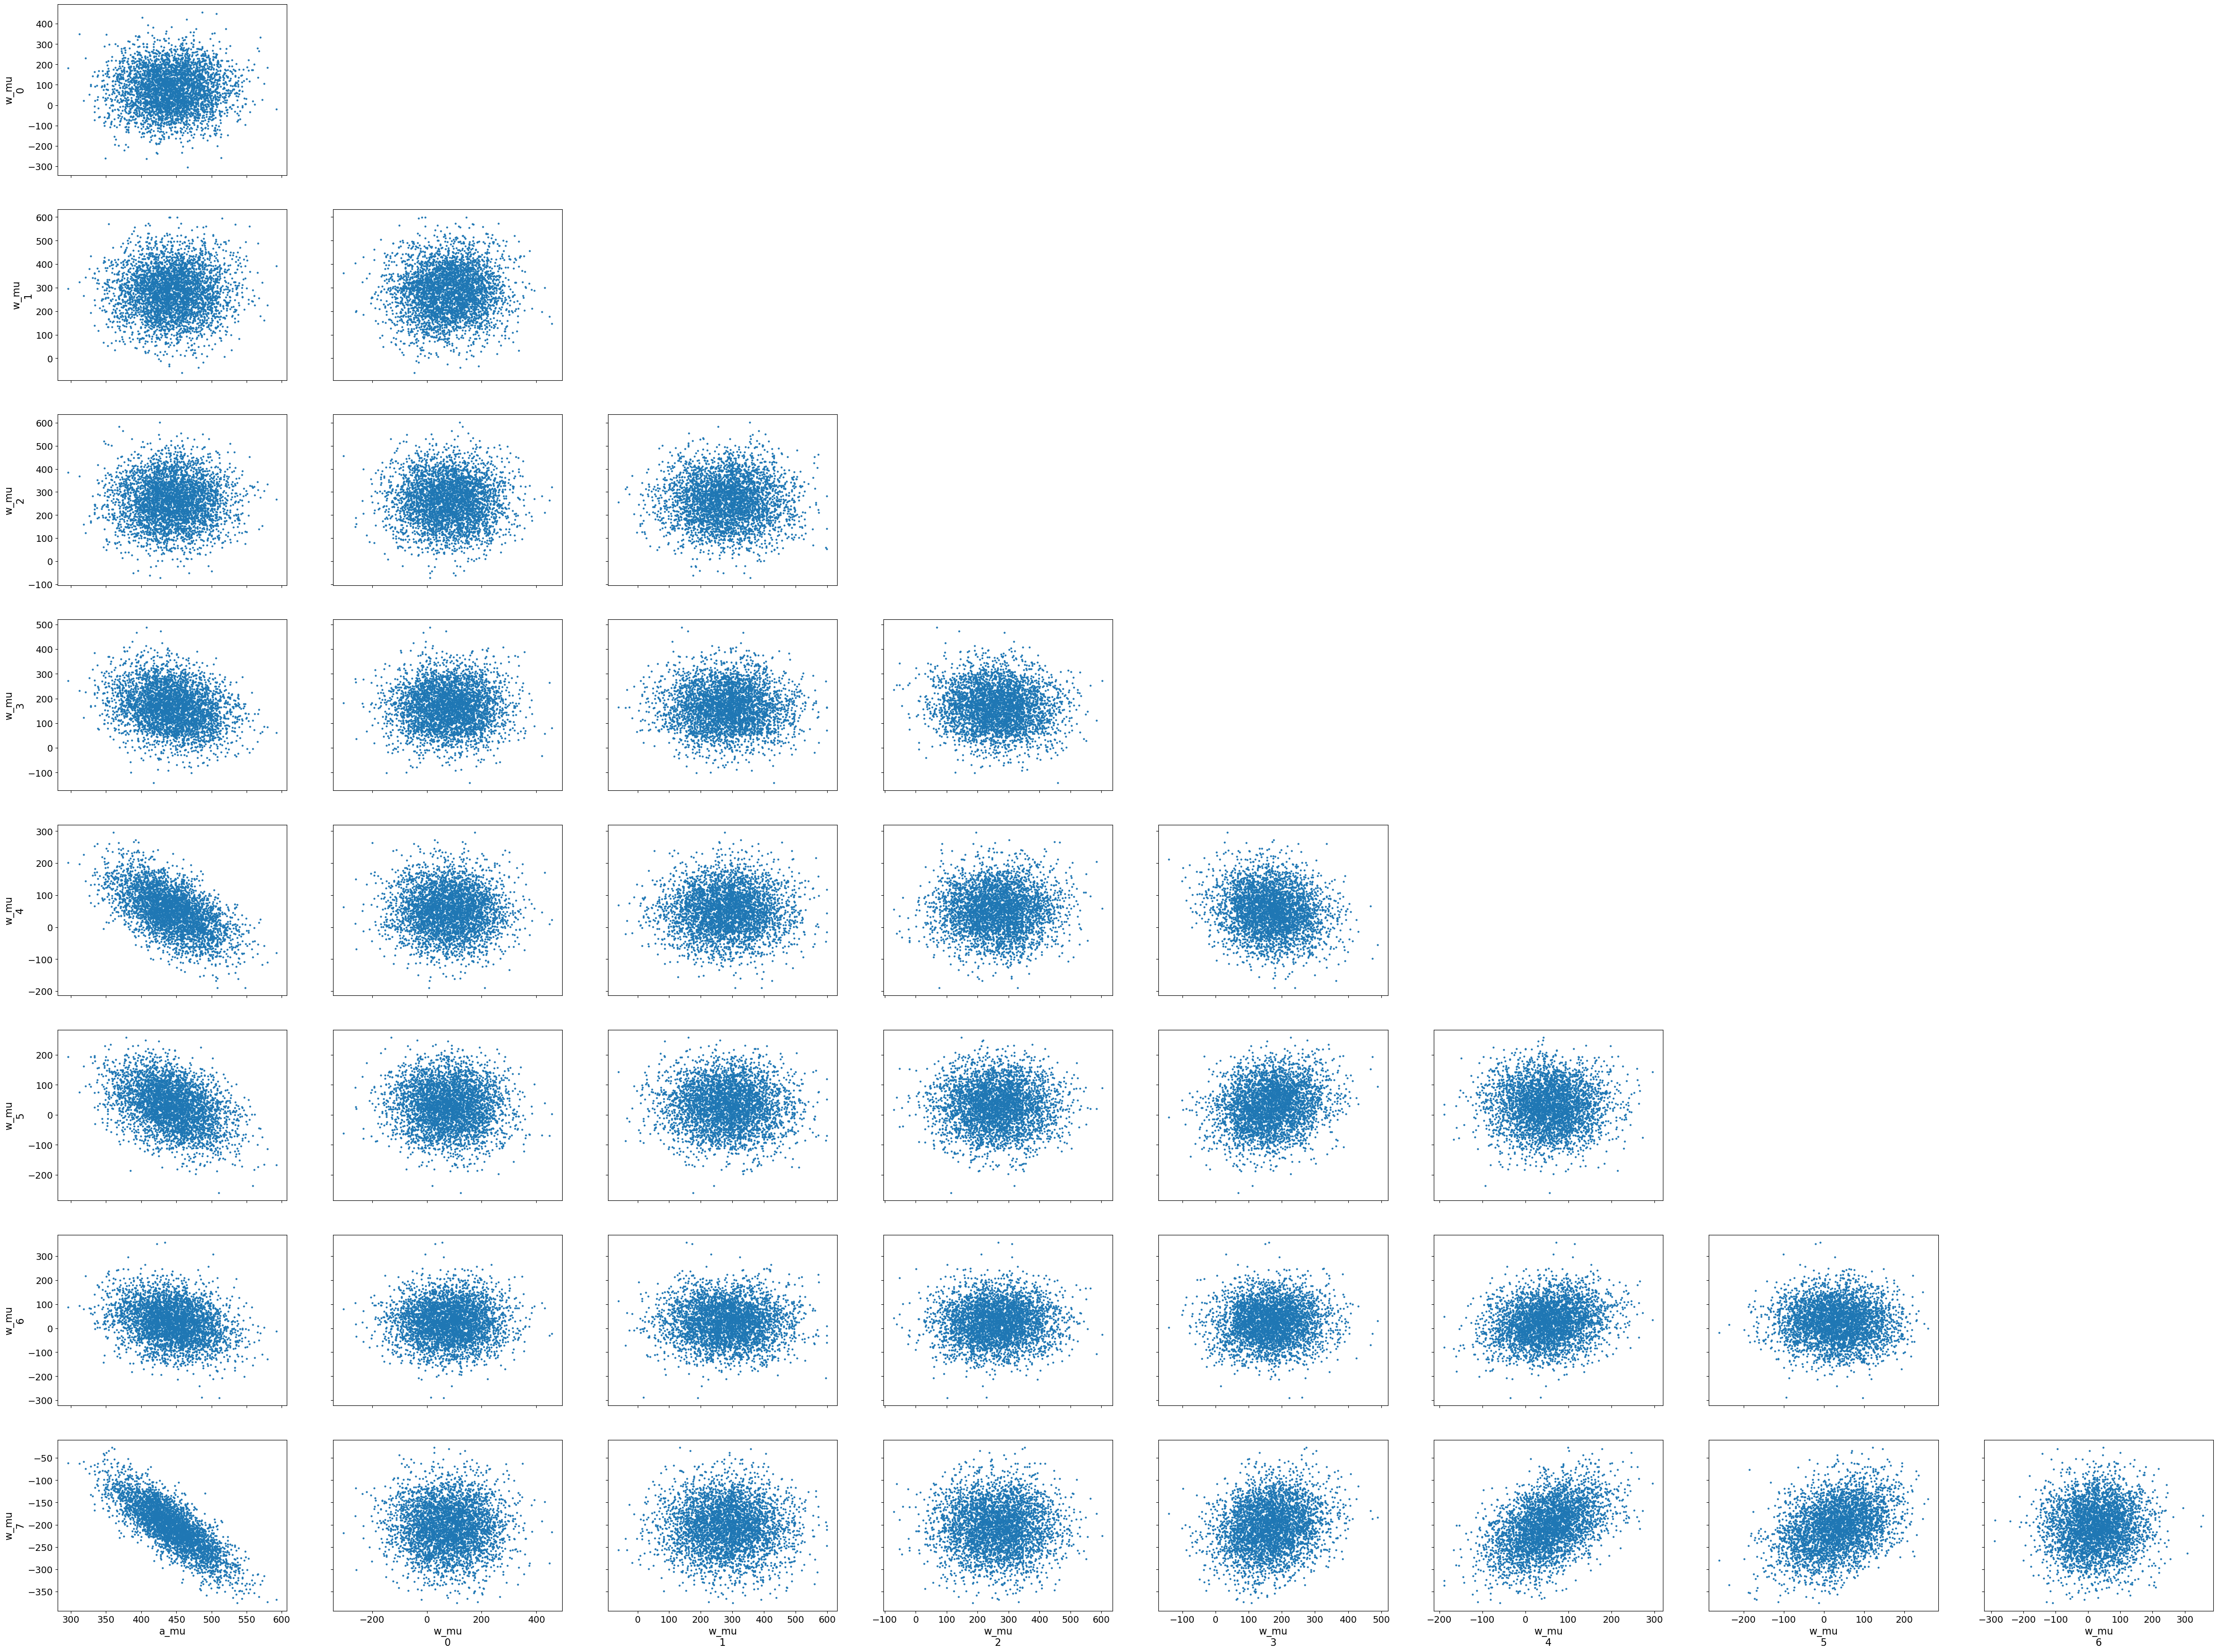

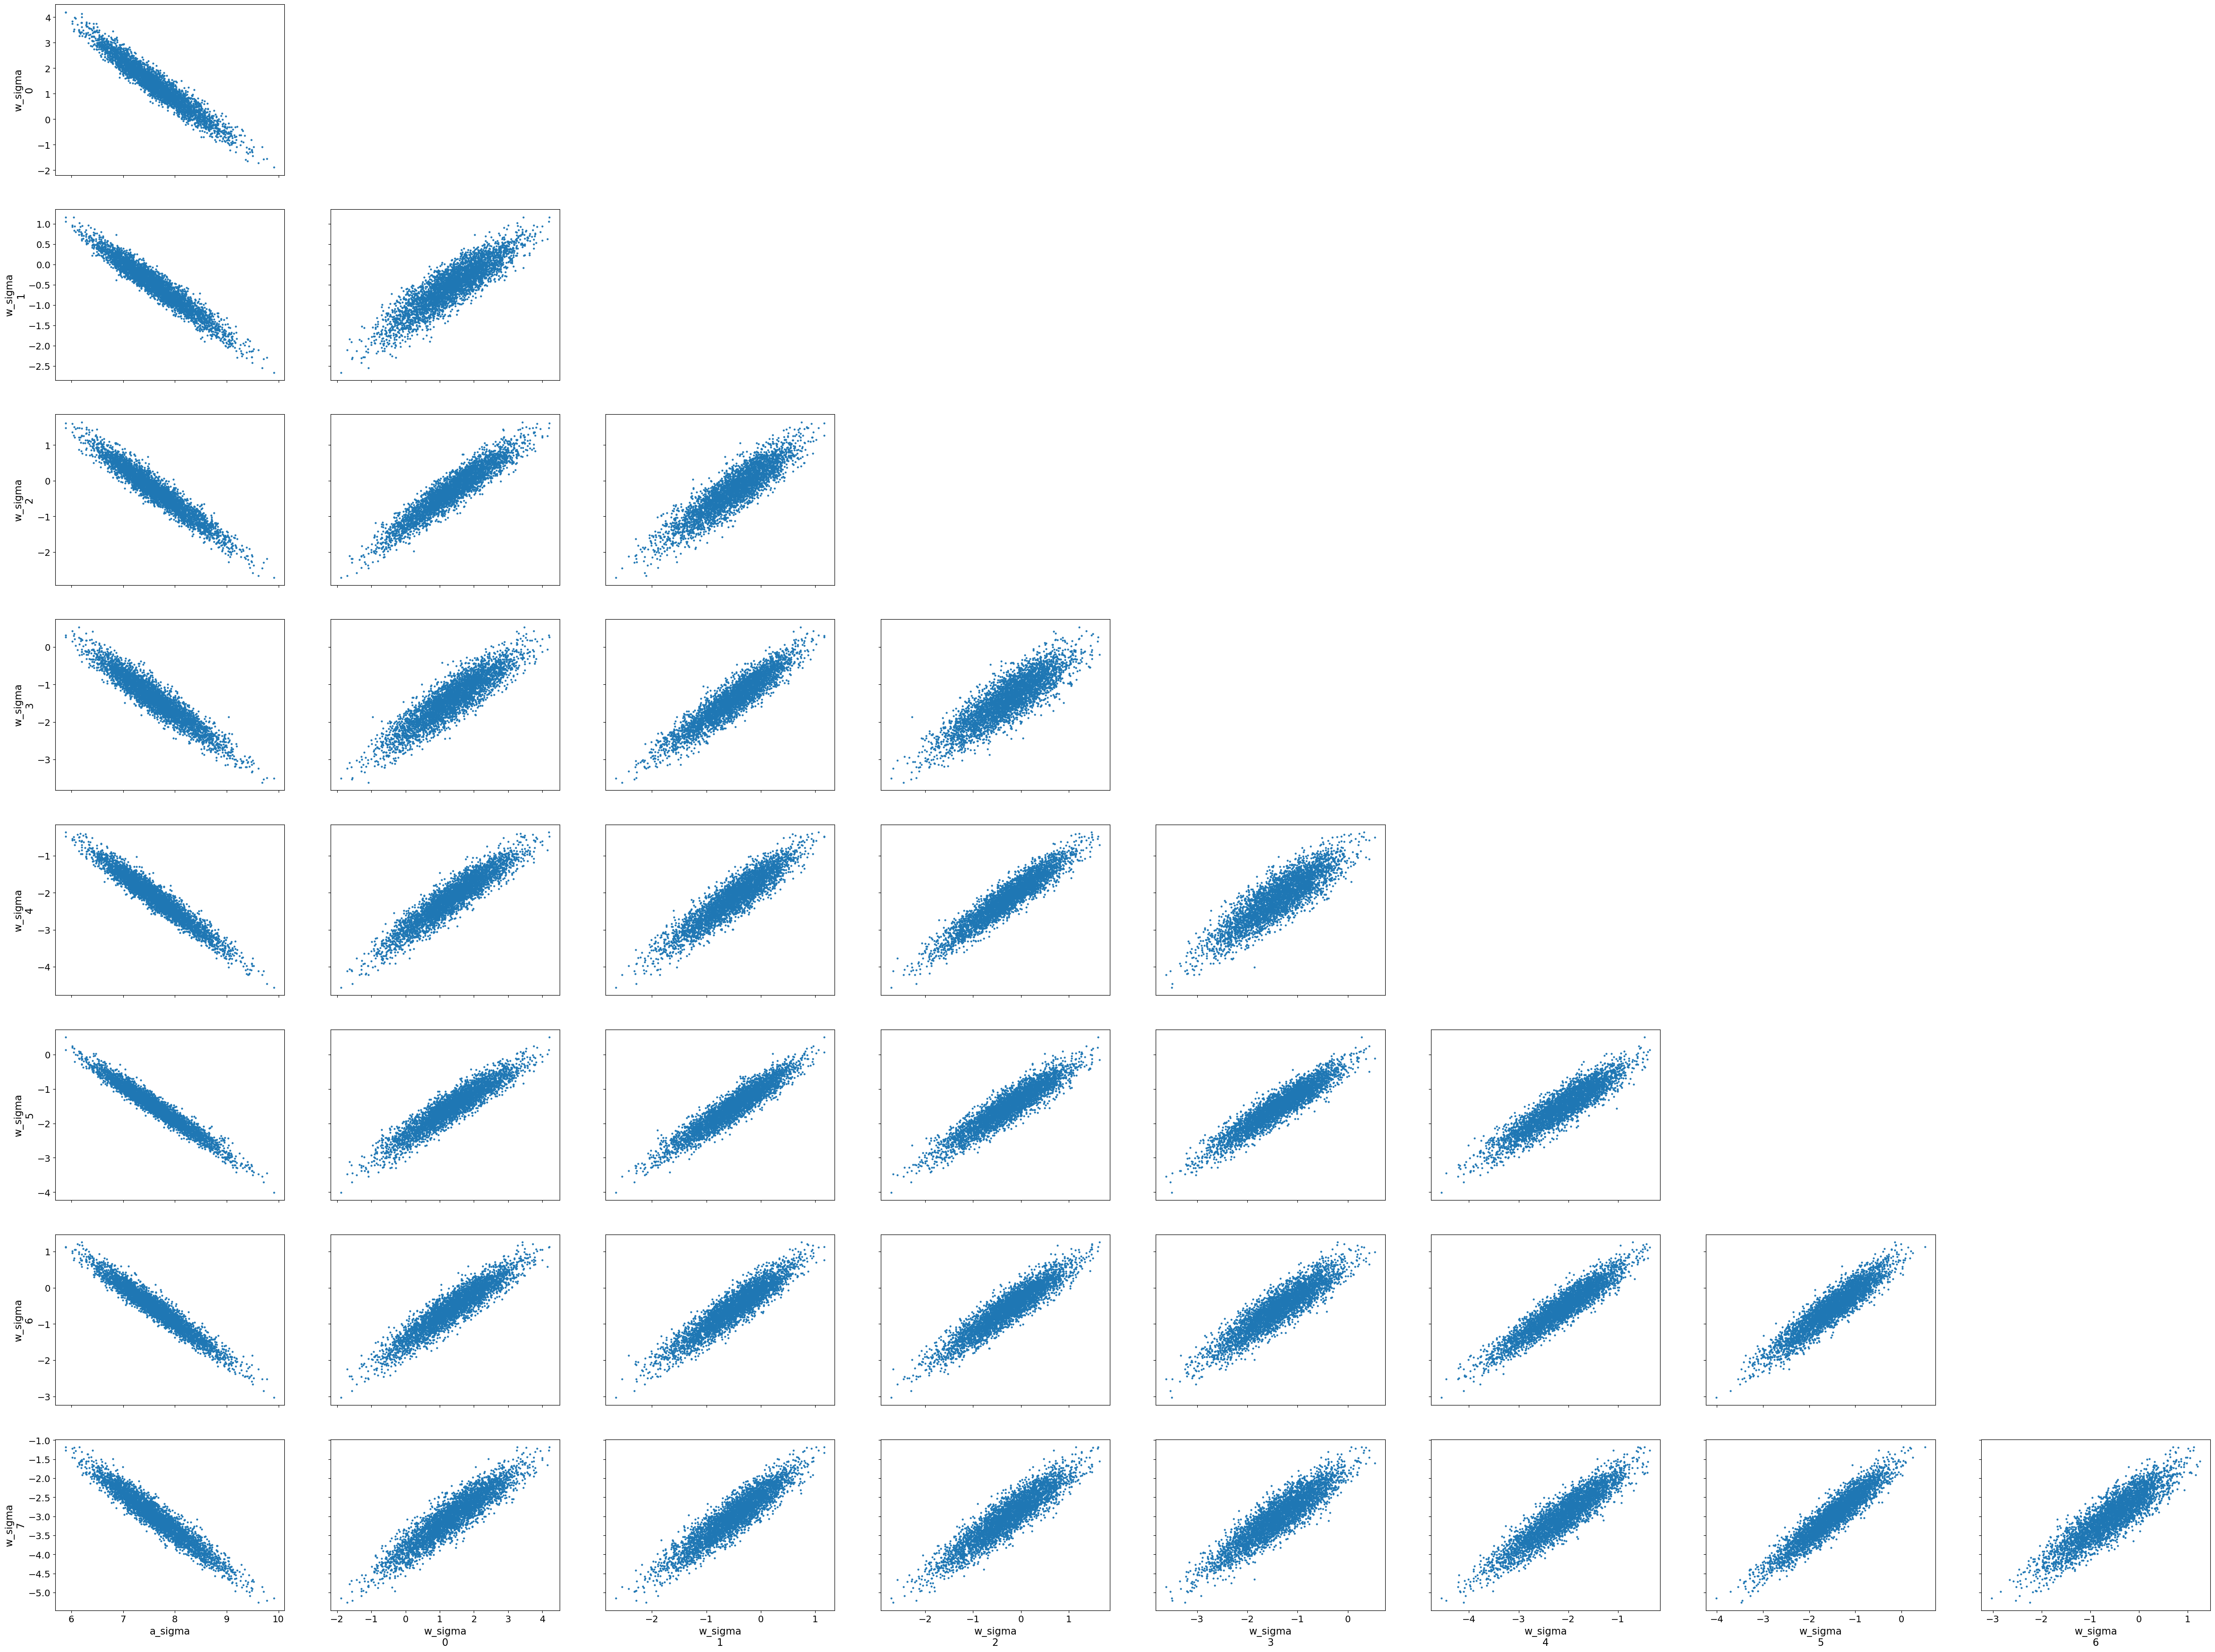

In [38]:
az.plot_rank(inference_2, ['~mu', '~sigma'])
az.plot_pair(inference_2, var_names=['a_mu', 'w_mu'], divergences=True)
az.plot_pair(inference_2, var_names=['a_sigma', 'w_sigma'], divergences=True)
az.summary(inference_2, ['~mu', '~sigma'])

In [40]:
print(inference_2.posterior.keys())

KeysView(<xarray.Dataset>
Dimensions:        (chain: 4, draw: 1000, w_mu_dim_0: 10, w_sigma_dim_0: 10,
                    mu_dim_0: 413, sigma_dim_0: 413)
Coordinates:
  * chain          (chain) int64 0 1 2 3
  * draw           (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * w_mu_dim_0     (w_mu_dim_0) int64 0 1 2 3 4 5 6 7 8 9
  * w_sigma_dim_0  (w_sigma_dim_0) int64 0 1 2 3 4 5 6 7 8 9
  * mu_dim_0       (mu_dim_0) int64 0 1 2 3 4 5 6 ... 407 408 409 410 411 412
  * sigma_dim_0    (sigma_dim_0) int64 0 1 2 3 4 5 6 ... 407 408 409 410 411 412
Data variables:
    a_mu           (chain, draw) float64 451.9 432.7 423.4 ... 426.6 431.3 511.8
    w_mu           (chain, draw, w_mu_dim_0) float64 189.9 171.6 ... -255.3
    a_sigma        (chain, draw) float64 9.29 8.796 7.554 ... 8.62 8.556 7.396
    w_sigma        (chain, draw, w_sigma_dim_0) float64 -0.3907 ... -3.663
    mu             (chain, draw, mu_dim_0) float64 524.1 477.8 ... 266.8 347.2
    sigma          (chain,

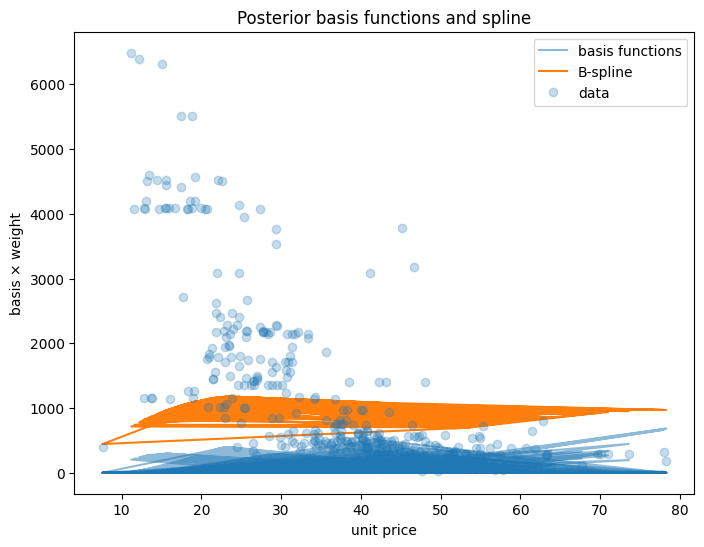

In [48]:
def plot_posterior_spline(a, w):
    plt.figure(figsize=(8, 6))
    plt.title('Posterior basis functions and spline')
    w_mean = w.mean(dim=['chain', 'draw']).values
    a_mean = a.mean(dim=['chain', 'draw']).values
    total = np.full(len(unit_price), a_mean)
    for i in range(B.shape[1]):
        weighted_basis = w_mean[i] * B[:, i]
        total += weighted_basis
        plt.plot(
            unit_price, weighted_basis,
            color='C0', alpha=0.5,
            label='basis functions' if i == 0 else None)
    plt.plot(unit_price, total, color='C1', label='B-spline')
    plt.plot(unit_price, mrt_distance, 'o', alpha=0.25, color='C0', label='data')
    plt.xlabel('unit price')
    plt.ylabel('basis × weight')
    plt.legend()
    return total
    
plot_posterior_spline(inference_2.posterior.mu, inference_2.posterior.mu);

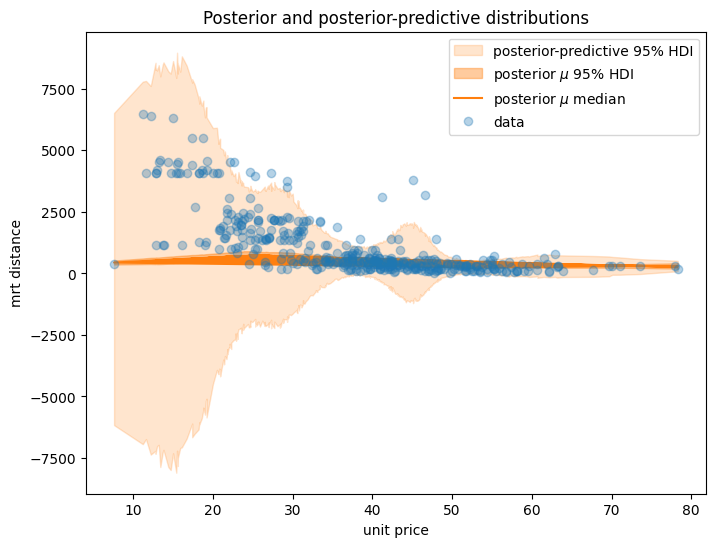

In [42]:
def plot_posterior_predictive_hdi(inference):
    plt.figure(figsize=(8, 6))
    plt.title('Posterior and posterior-predictive distributions')
    az.plot_hdi(
        unit_price, inference_2.posterior_predictive.D,
        hdi_prob=0.95, smooth=False, color='C1',
        fill_kwargs={'alpha': 0.2, 'label': 'posterior-predictive 95% HDI'})
    az.plot_hdi(
        unit_price, inference_2.posterior.mu,
        hdi_prob=0.95, smooth=False, color='C1',
        fill_kwargs={'alpha': 0.4, 'label': 'posterior $\mu$ 95% HDI'})
    plt.plot(
        unit_price, inference_2.posterior.mu.median(dim=['chain', 'draw']).values,
        color='C1', alpha=1, label='posterior $\mu$ median')
    plt.plot(unit_price, mrt_distance, 'o', alpha=0.33, color='C0', label='data')
    plt.xlabel('unit price')
    plt.ylabel('mrt distance')
    plt.legend()

plot_posterior_predictive_hdi(inference)

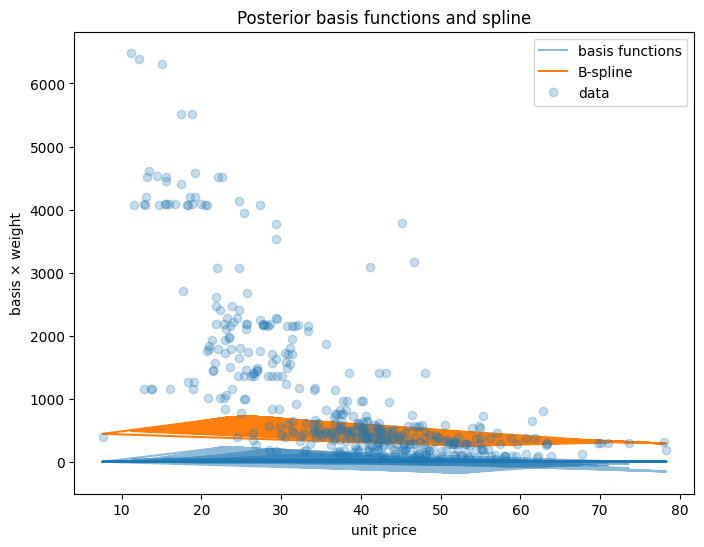

In [43]:
plot_posterior_spline(inference_2.posterior.a_mu, inference_2.posterior.w_mu);

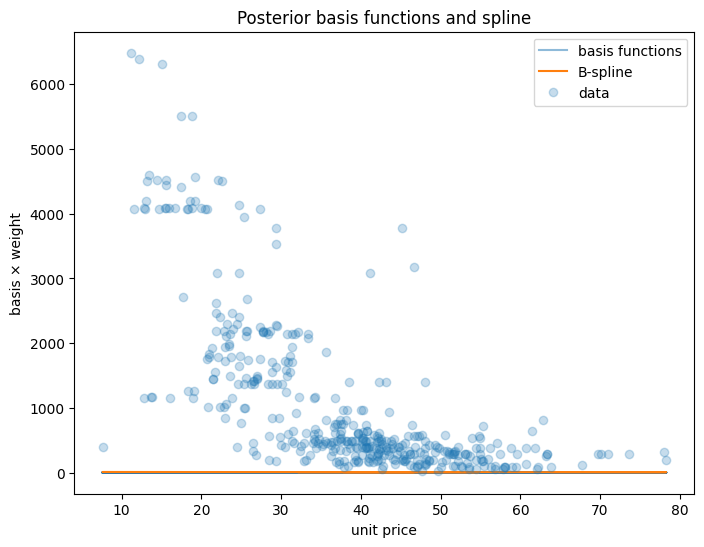

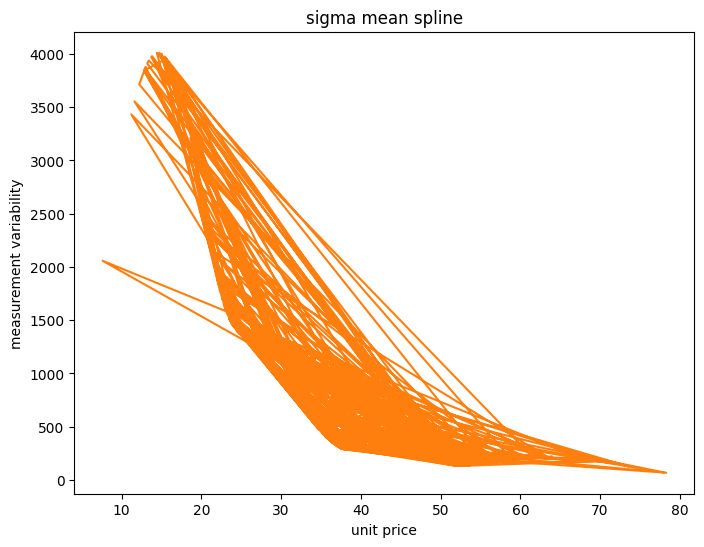

In [44]:
log_spline = plot_posterior_spline(inference_2.posterior.a_sigma, inference_2.posterior.w_sigma)

plt.figure(figsize=(8, 6))
plt.title('sigma mean spline')
plt.xlabel('unit price')
plt.ylabel('measurement variability')
plt.plot(unit_price, np.exp(log_spline), color='C1')
plt.show()

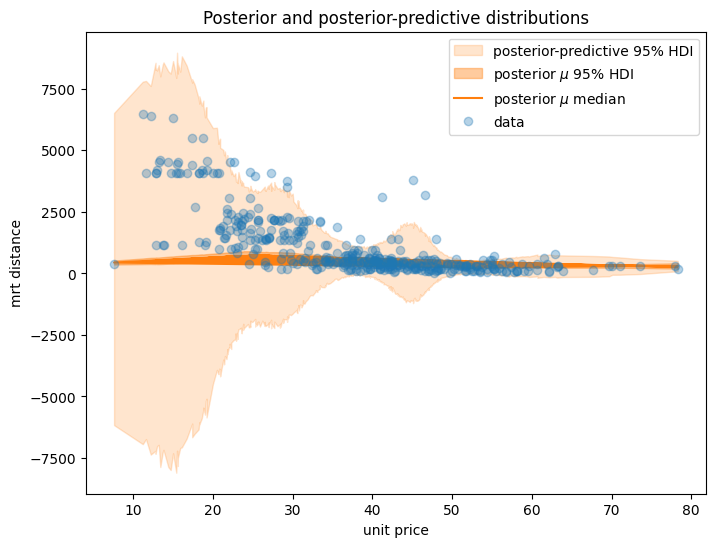

In [45]:
plot_posterior_predictive_hdi(inference_2)